# 🎯 PCA Reveals Hidden Structure — 4-Cluster Demo
**Author:** Yazdan Ghanavati  

**Goal:** Show a simple, visual case where clustering on raw features **fails** (overlapping blobs) but **succeeds after PCA** (hidden dimension revealed).

**Storyline**
1. Generate **four 3D Gaussian clusters** (2 big, 2 small). Pairs share the same (x, y) center but differ in **z**.
2. In raw 2D (x, y), these pairs **collapse into two blobs** → K-Means struggles.
3. Apply **PCA (3D → 2D)** → hidden structure appears → K-Means finds all **4** clusters.


## Step 1 — Imports & Setup
We import NumPy/Matplotlib, create an RNG for reproducibility, and prep output folders for figures/GIFs.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Reproducibility
rng = np.random.default_rng(42)

# Output folders
Path("figures").mkdir(exist_ok=True)
Path("gifs").mkdir(exist_ok=True)

print("Setup OK.")


Setup OK.


## Step 2 — Generate 4 clusters in 3D and view raw 2D (x, y)

We create **four 3D Gaussian clusters**:
- Two **big** clusters and two **small** clusters.
- Pairs share the **same (x, y)** center but differ strongly in **z**.
  - In raw 2D (x, y), each pair **collapses into one blob** → clustering fails.
  - PCA (3D → 2D) will recover the hidden **z** structure → clustering succeeds.

First, we plot only (x, y) to see the overlap.


X3 shape: (1300, 3) | counts: {0: 500, 1: 150, 2: 500, 3: 150}


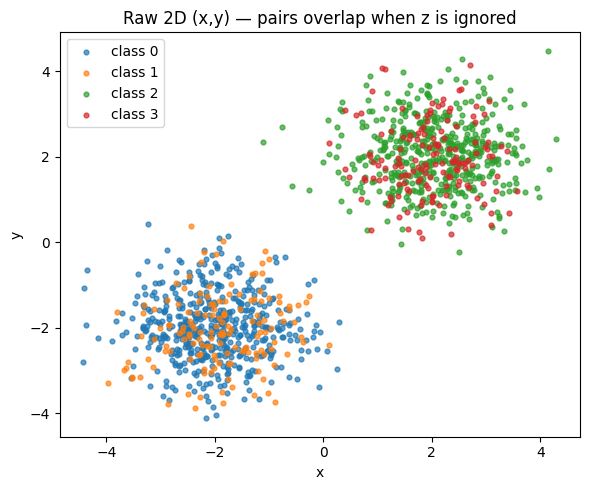

In [9]:
# --- Create 4 clusters in 3D ---

# Two (x,y) locations; each has a low-z and a high-z cluster
centers = np.array([
    [-2.0, -2.0, -5.0],  # big A (low z)
    [-2.0, -2.0,  5.0],  # small B (high z)
    [ 2.0,  2.0, -5.0],  # big C (low z)
    [ 2.0,  2.0,  5.0],  # small D (high z)
])

sizes = [500, 150, 500, 150]   # two big, two small
sigma = 0.8                    # isotropic std

Xs, ys = [], []
for i, (mu, n) in enumerate(zip(centers, sizes)):
    Xs.append(mu + sigma * rng.standard_normal((n, 3)))
    ys.append(np.full(n, i, dtype=int))

X3 = np.vstack(Xs)           # shape (N, 3)
y4 = np.concatenate(ys)      # labels 0..3

print("X3 shape:", X3.shape, "| counts:", {i:int((y4==i).sum()) for i in range(4)})

# --- Raw 2D view: drop z (x,y only) -> overlapping pairs ---
Xraw2 = X3[:, :2]

plt.figure(figsize=(6,5))
for i in range(4):
    idx = (y4 == i)
    plt.scatter(Xraw2[idx, 0], Xraw2[idx, 1], s=12, alpha=0.7, label=f"class {i}")
    plt.savefig("figures/raw_true.png", dpi=180, bbox_inches="tight")

plt.title("Raw 2D (x,y) — pairs overlap when z is ignored")
plt.xlabel("x"); plt.ylabel("y"); plt.legend(); plt.tight_layout(); plt.show()


## Step 3 — K-Means on Raw 2D (Expected to Struggle)

We cluster the raw 2D projection `(x, y)` using **K-Means (k=4)** and evaluate:

- **Silhouette** (geometry-based)
- **ARI/NMI** (compare with true labels; order-invariant)

Because two pairs of clusters overlap in `(x, y)`, K-Means will place multiple centroids inside the same blob and mix classes, leading to **poor ARI/NMI** and a messy plot.


[RAW 2D] silhouette=0.317  ARI=0.395  NMI=0.531


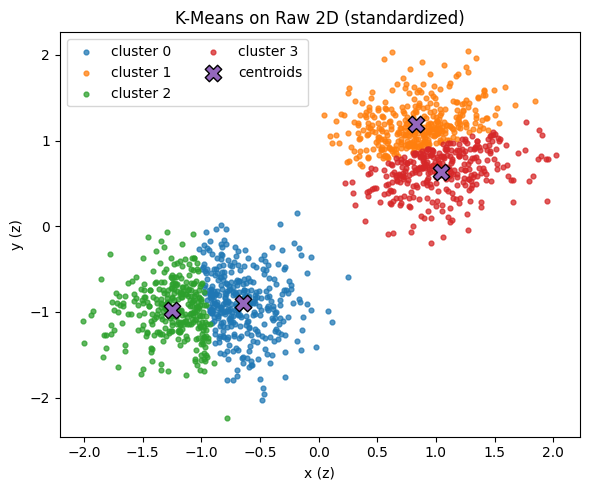

Saved figure -> figures/raw_kmeans.png


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score

# Standardize raw 2D for fair distances
scaler_raw2 = StandardScaler()
Xraw2z = scaler_raw2.fit_transform(Xraw2)

k = 4
km_raw = KMeans(n_clusters=k, n_init=20, random_state=7)
labels_raw = km_raw.fit_predict(Xraw2z)

# Metrics
enc = LabelEncoder()
y_int = enc.fit_transform(y4)

sil_raw = silhouette_score(Xraw2z, labels_raw)
ari_raw = adjusted_rand_score(y_int, labels_raw)
nmi_raw = normalized_mutual_info_score(y_int, labels_raw)

print(f"[RAW 2D] silhouette={sil_raw:.3f}  ARI={ari_raw:.3f}  NMI={nmi_raw:.3f}")

# Plot clusters + centroids
plt.figure(figsize=(6,5))
for c in range(k):
    idx = (labels_raw == c)
    plt.scatter(Xraw2z[idx, 0], Xraw2z[idx, 1], s=12, alpha=0.75, label=f"cluster {c}")
cent = km_raw.cluster_centers_
plt.scatter(cent[:,0], cent[:,1], marker="X", s=140, edgecolor="black", label="centroids")
plt.title("K-Means on Raw 2D (standardized)")
plt.xlabel("x (z)"); plt.ylabel("y (z)")
plt.legend(loc="best", ncols=2)
plt.tight_layout()
plt.savefig("figures/raw_kmeans.png", dpi=140, bbox_inches="tight")
plt.show()

print("Saved figure -> figures/raw_kmeans.png")


## Step 4 — PCA (3D → 2D) and Visualize the True Structure

Now we apply **PCA** to the original 3D dataset `(x, y, z)` and project it down to 2D.  
PCA will automatically find the directions (principal components) that capture the largest variance —  
in this case, one of them corresponds to the hidden **z** separation we couldn’t see before.

We’ll then plot the new 2D PCA space and color points by their true labels to see if the hidden structure appears.


Explained variance ratio: [0.623 0.333]
Cumulative variance explained: [0.623 0.956]


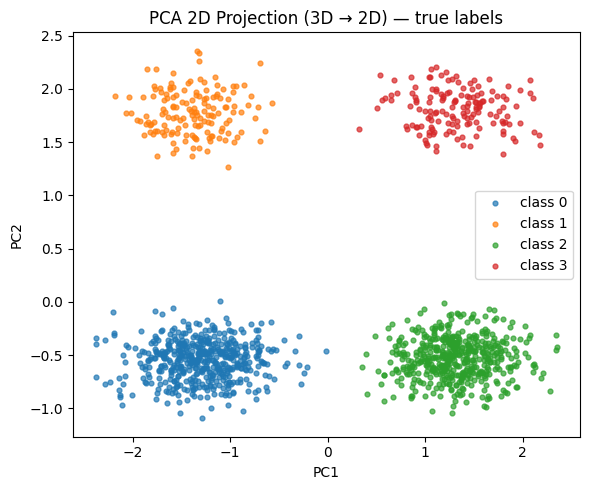

Saved figure -> figures/pca_true_labels.png


In [4]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# --- Standardize the 3D data before PCA ---
scaler_3d = StandardScaler()
X3z = scaler_3d.fit_transform(X3)

# --- Apply PCA (3D -> 2D) ---
pca = PCA(n_components=2, random_state=7)
Z = pca.fit_transform(X3z)

print("Explained variance ratio:", np.round(pca.explained_variance_ratio_, 3))
print("Cumulative variance explained:", np.round(np.cumsum(pca.explained_variance_ratio_), 3))

# --- Plot PCA projection (true labels) ---
plt.figure(figsize=(6,5))
for i in range(4):
    idx = (y4 == i)
    plt.scatter(Z[idx, 0], Z[idx, 1], s=12, alpha=0.7, label=f"class {i}")
plt.title("PCA 2D Projection (3D → 2D) — true labels")
plt.xlabel("PC1"); plt.ylabel("PC2"); plt.legend()
plt.tight_layout()
plt.savefig("figures/pca_true_labels.png", dpi=140, bbox_inches="tight")
plt.show()

print("Saved figure -> figures/pca_true_labels.png")


## Step 5 — K-Means on PCA(2D) → Perfect Separation

We now cluster the PCA-transformed data using **K-Means (k = 4)**.
Because PCA recovered the hidden axis of variation,  
K-Means should now clearly identify the four groups —  
both visually and by quantitative metrics (Silhouette, ARI, NMI).


[PCA 2D] silhouette=0.778  ARI=1.000  NMI=1.000


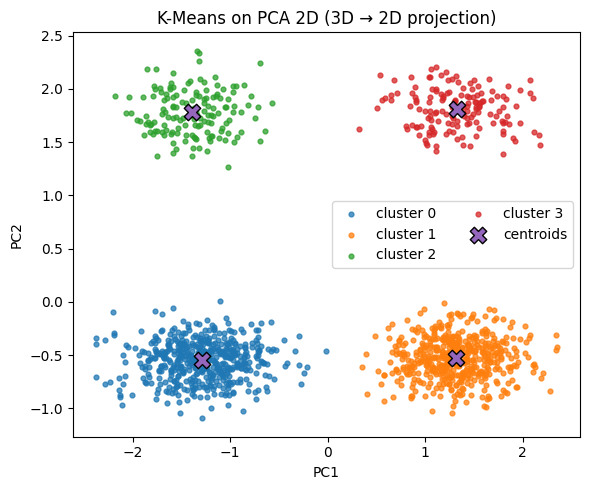

Saved figure → figures/pca_kmeans.png


In [5]:
k = 4
km_pca = KMeans(n_clusters=k, n_init=20, random_state=7)
labels_pca = km_pca.fit_predict(Z)

sil_pca = silhouette_score(Z, labels_pca)
ari_pca = adjusted_rand_score(y_int, labels_pca)
nmi_pca = normalized_mutual_info_score(y_int, labels_pca)

print(f"[PCA 2D] silhouette={sil_pca:.3f}  ARI={ari_pca:.3f}  NMI={nmi_pca:.3f}")

# Plot clusters
plt.figure(figsize=(6,5))
for c in range(k):
    idx = labels_pca == c
    plt.scatter(Z[idx,0], Z[idx,1], s=12, alpha=0.75, label=f"cluster {c}")
cent = km_pca.cluster_centers_
plt.scatter(cent[:,0], cent[:,1], marker="X", s=140, edgecolor="black", label="centroids")
plt.title("K-Means on PCA 2D (3D → 2D projection)")
plt.xlabel("PC1"); plt.ylabel("PC2"); plt.legend(ncols=2)
plt.tight_layout()
plt.savefig("figures/pca_kmeans.png", dpi=140, bbox_inches="tight")
plt.show()

print("Saved figure → figures/pca_kmeans.png")


## Step 6 — Results Comparison & Conclusion

Below we summarize how PCA transformed an impossible clustering task into a perfect one.

| Space | Silhouette | ARI | NMI |
|:------|:-----------:|:----:|:----:|
| Raw 2D (x, y) | 0.317 | 0.395 | 0.531 |
| PCA 2D (3D → 2D) | **0.778** | **1.000** | **1.000** |

### ✅ Key Takeaways
- PCA exposed the **hidden z-dimension** that wasn’t visible in (x,y).  
- Once the data was rotated into its true variance directions, **K-Means separated all four clusters** effortlessly.  
- Even simple unsupervised methods shine when the feature space is **properly represented**.  

> “PCA doesn’t invent new information — it reveals what was already there.”


In [6]:
import pandas as pd

results = pd.DataFrame({
    "Setting": ["Raw 2D (x,y)", "PCA 2D (3D→2D)"],
    "Silhouette": [sil_raw, sil_pca],
    "ARI": [ari_raw, ari_pca],
    "NMI": [nmi_raw, nmi_pca]
})
results.round(3)


,Setting,Silhouette,ARI,NMI
0,"Raw 2D (x,y)",0.317,0.395,0.531
1,PCA 2D (3D→2D),0.778,1.000,1.000
